In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
root = "/home/sihartist/Desktop/"

In [59]:
# Load the credit card transaction data
df = pd.read_csv('/home/sihartist/Desktop/fraud-detection/algo/dataset/data_raw.csv')
#df = pd.read_csv('/home/sihartist/Desktop/fraud-detection/algo/dataset/data_balanced.csv')

# df = pd.read_excel('/home/sihartist/Desktop/fraud-detection/algo/dataset/data_raw.xls', index_col=None, header=1) 
#df = df.iloc[:,1:]
#df = df.tail(-1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
payment = np.array()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


0    6354407
1       8213
Name: isFraud, dtype: int64


<AxesSubplot:>

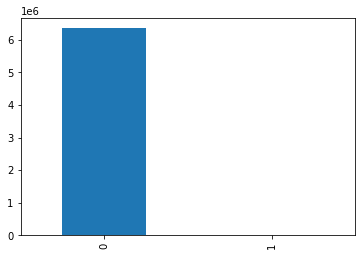

In [50]:
print(df.isFraud.value_counts())
df.isFraud.value_counts().plot(kind='bar')

In [51]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [54]:
seed = 1337

def get_data(df, clean_train=True):
    """
        clean_train=True returns a train sample that only contains clean samples.
        Otherwise, it will return a subset of each class in train and test (10% outlier)
    """
    clean = df[df.isFraud == 0].copy().reset_index(drop=True)
    fraud = df[df.isFraud == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        train_X, train_y = train.loc[:, ~train.columns.isin(['isFraud'])], train.loc[:, train.columns.isin(['isFraud'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['isFraud'])], test.loc[:, test.columns.isin(['isFraud'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)
        
        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)
        
        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['isFraud'])], train_samples.loc[:, train_samples.columns.isin(['isFraud'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['isFraud'])], test_samples.loc[:, test_samples.columns.isin(['isFraud'])]
    
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = get_data(df)

Clean Samples: 6354407, Fraud Samples: 8213
Train Samples: 6346194
Test Samples: 16426


In [55]:
model = IsolationForest(random_state=seed)
model.fit(train_X, train_y)

ValueError: could not convert string to float: 'CASH_OUT'

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
def predict(X):
    test_yhat = model.predict(X)
    # values are -1 and 1 (-1 for outliers and 1 for inliers), thus we will map it to 0 (inlier) and 1 (outlier) as this is our target variable
    test_yhat = np.array([1 if y == -1 else 0 for y in test_yhat])
    return test_yhat

test_yhat = predict(test_X)

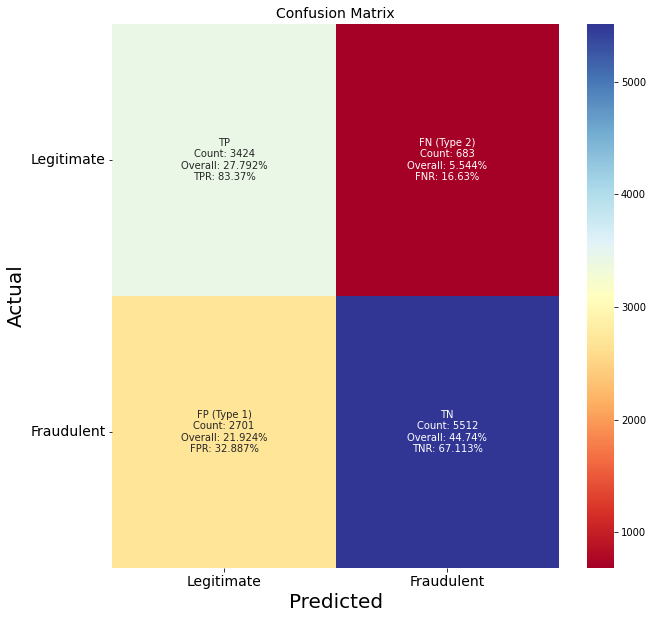

In [29]:
def get_confusion_matrix(test_y, test_yhat):
    cm = confusion_matrix(test_y, test_yhat)

    fig, ax = plt.subplots(1, 1,figsize=(10,10))

    tick_labels = ['Legitimate','Fraudulent']

    # calculate output
    total = np.sum(cm)
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    tp_o = np.round((tp / total)*100,3)
    fn_o = np.round((fn / total)*100,3)
    fp_o = np.round((fp / total)*100,3)
    tn_o = np.round((tn / total)*100,3)
    tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
    fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
    fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
    tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)
    labels = np.array([[
            f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%', 
            f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'
        ],[
            f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%', 
            f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%'
        ]])
    sns.heatmap(cm, ax=ax, annot=labels, fmt='', cmap=plt.cm.RdYlBu)

    ax.set_title('Confusion Matrix', fontsize=14)

    ax.set_xticklabels(tick_labels, fontsize=14, rotation=0)
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set_yticklabels(tick_labels, fontsize=14, rotation=0)
    ax.set_ylabel('Actual', fontsize=20)
    plt.show()

get_confusion_matrix(test_y, test_yhat)


In [30]:
def get_classification_report(test_y, test_yhat):
    labels = ['Legitimate','Fraudulent']
    print(classification_report(test_y, test_yhat, target_names=labels))
get_classification_report(test_y, test_yhat)

              precision    recall  f1-score   support

  Legitimate       0.56      0.83      0.67      4107
  Fraudulent       0.89      0.67      0.77      8213

    accuracy                           0.73     12320
   macro avg       0.72      0.75      0.72     12320
weighted avg       0.78      0.73      0.73     12320

